In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

# 5 minutes prediction/forecasting

In [2]:
# Load the data
data = pd.read_csv("/kaggle/input/btc-usd-full-dataset/btc_30m.csv")
data = data.loc[::-1].reset_index(drop=True)
data = data[['close']]

In [3]:
# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Split the data into training and test sets
train_data = data[:int(len(data) * 0.8)]
test_data = data[int(len(data) * 0.8):]

In [4]:
# Define the lookback and batch size
lookback = 20
batch_size = 32

In [5]:
# Create a generator function to generate batches of training data
def generator(data, lookback, batch_size):
    i = 0
    while i + lookback < len(data):
        x = np.array([data[i:i+lookback]])
        y = np.array([data[i+lookback]])
        i += 1
        yield x, y

# Create the RNN model
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(30, input_shape=(lookback, 1), activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(5))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
train_gen = generator(train_data, lookback, batch_size)
model.fit(train_gen, epochs=20, steps_per_epoch=len(train_data) // batch_size)

# Evaluate the model on the test data
test_gen = generator(test_data, lookback, batch_size)
mse = model.evaluate(test_gen, steps=len(test_data) // batch_size)

# Make predictions on new data
x = np.array([data[-lookback:]])
prediction = model.predict(x)
prediction = scaler.inverse_transform(prediction)
print("Prediction:", prediction)
print("MSE:", mse)

Epoch 1/20
1782/1782 [==============================] - 13s 6ms/step - loss: 0.0412
Epoch 2/20
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0100
Epoch 3/20
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0059
Epoch 4/20
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0016
Epoch 5/20
1782/1782 [==============================] - 12s 7ms/step - loss: 7.5544e-04
Epoch 6/20
1782/1782 [==============================] - 11s 6ms/step - loss: 1.1884e-04
Epoch 7/20
1782/1782 [==============================] - 11s 6ms/step - loss: 2.3973e-04
Epoch 8/20
1782/1782 [==============================] - 11s 6ms/step - loss: 5.3862e-04
Epoch 9/20
1782/1782 [==============================] - 11s 6ms/step - loss: 2.7540e-04
Epoch 10/20
1782/1782 [==============================] - 11s 6ms/step - loss: 2.8385e-04
Epoch 11/20
1782/1782 [==============================] - 11s 6ms/step - loss: 2.9248e-04
Epoch 12/20
1782/1782 [=======================

In [6]:
# Replace 'your_model_name.h5' with the desired file name
model.save('5pred.h5')

# LSTM approach for comparison

In [24]:
from tensorflow.keras.models import load_model
btc_data = pd.read_csv("/kaggle/input/btc-usd-full-dataset/btc_30m.csv")
# Load the saved model
loaded_model = load_model('new_model_5pred.h5')
def make_predictions(model, data, lookback=20):
    # Normalize the data using the same scaler used for training
    scaled_data = scaler.transform(data[['close', 'RSI', 'MACD', 'MACD_signal', 'upper_band', 'middle_band', 'lower_band']])

    # Prepare the dataset for predictions
    X, y = create_dataset(scaled_data, lookback)

    # Predict using the loaded model
    predictions = model.predict(X)

    # Inverse transform the predictions to the original price scale
    predictions = scaler.inverse_transform(np.concatenate((X[:, -1, 0].reshape(-1, 1), predictions), axis=1))[:, 1]

    return predictions
# Load and preprocess the 'btc_30m.csv' data (replace with your actual preprocessing steps)
btc_30m_data = pd.read_csv('path_to_btc_30m.csv')
btc_30m_data['RSI'] = talib.RSI(btc_30m_data['close'].values, timeperiod=14)
btc_30m_data['MACD'], btc_30m_data['MACD_signal'], _ = talib.MACD(btc_30m_data['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
btc_30m_data['upper_band'], btc_30m_data['middle_band'], btc_30m_data['lower_band'] = talib.BBANDS(btc_30m_data['close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
btc_30m_data.dropna(inplace=True)

# Make predictions on the 'btc_30m.csv' data
btc_30m_predictions = make_predictions(loaded_model, btc_30m_data, lookback=20)

# Print or visualize the predictions as needed
print(btc_30m_predictions)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_btc_30m.csv'

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

data = pd.read_csv("/kaggle/input/btc-usd-full-dataset/btc_15m.csv")
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['close', 'RSI', 'MACD', 'MACD_signal', 'upper_band', 'middle_band', 'lower_band']])

# Prepare the dataset for LSTM
def create_dataset(data, lookback=20):
    X, y = [], []
    for i in range(len(data) - lookback - 1):
        X.append(data[i:(i + lookback), :])
        y.append(data[i + lookback, 0])  # Predicting the 'close' price
    return np.array(X), np.array(y)

lookback = 20
X, y = create_dataset(scaled_data, lookback)

# Split the data into training and test sets (adjust the split as per your data)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting the 'close' price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to the original price scale
y_pred = scaler.inverse_transform(np.concatenate((X_test[:, -1, 0].reshape(-1, 1), y_pred), axis=1))[:, 1]
y_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, 0].reshape(-1, 1), y_test.reshape(-1, 1)), axis=1))[:, 1]

# Calculate evaluation metrics
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

**End of new method**

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
btc_data_path = '/kaggle/input/btc-usd-full-dataset/btc_30m.csv'
btc_data = pd.read_csv(btc_data_path)

# Load the model
model_path = '/kaggle/working/5pred.h5'
model = tf.keras.models.load_model(model_path)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
btc_data_scaled = scaler.fit_transform(btc_data[['close']])

# Function to create a dataset compatible with the LSTM model's expected input
def create_dataset(data, timesteps):
    X = []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps), 0])
    return np.array(X)

# Reshape data for LSTM model
timesteps = model.input_shape[1]
features = model.input_shape[2]
btc_data_reshaped = create_dataset(btc_data_scaled, timesteps)
btc_data_reshaped = np.reshape(btc_data_reshaped, (btc_data_reshaped.shape[0], timesteps, features))

# Make predictions
predictions = model.predict(btc_data_reshaped)

# Inverse transform to get actual price values
predicted_prices = scaler.inverse_transform(predictions)

print(predicted_prices[:5])  # Display the first 5 predicted values

2228/2228 [==============================] - 7s 3ms/step
[[8869.8955 8869.8955 8869.8955 8869.8955 8869.8955]
 [8869.905  8869.905  8869.905  8869.905  8869.905 ]
 [8869.899  8869.899  8869.899  8869.899  8869.899 ]
 [8870.028  8870.028  8870.028  8870.028  8870.028 ]
 [8870.036  8870.036  8870.036  8870.036  8870.036 ]]


In [20]:
!pip install streamlit

  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/e9/07/63a6e890c9b998a6318b46c2a34377fd1a3e01a94c427d82bfb2472b7c16/streamlit-1.30.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for validators<1,>=0.2 from https://files.pythonhosted.org/packages/3a/0c/785d317eea99c3739821718f118c70537639aa43f96bfa1d83a71f68eaf6/validators-0.22.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 34.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 64.6 MB/s eta 0:00:00:00:010:01m


In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import streamlit as st
from sklearn.preprocessing import MinMaxScaler

# Function to preprocess data
def preprocess_data(data, scaler):
    # Focus on the 'close' price for prediction
    data = data[['close']]
    scaled_data = scaler.transform(data)
    return scaled_data

# Load models (adjust paths as needed)
model_5pred = tf.keras.models.load_model('/kaggle/working/5pred.h5')
# Initialize scaler (use the same parameters as during training)
scaler = MinMaxScaler(feature_range=(0, 1))

# Streamlit interface
st.title('Bitcoin Price Prediction')

uploaded_file = st.file_uploader("Upload a CSV file", type="csv")
if uploaded_file is not None:
    data = pd.read_csv(uploaded_file)
    # Fit the scaler on the uploaded data
    scaler.fit(data[['close']])
    preprocessed_data = preprocess_data(data, scaler)

    # Make predictions (modify according to your model's input requirements)
    predictions = model_5pred.predict(np.expand_dims(preprocessed_data, axis=0))

    # Inverse transform to get actual price values
    predicted_prices = scaler.inverse_transform(predictions[0])

    # Plotting predictions vs actual prices
    plt.figure(figsize=(10, 6))
    plt.plot(data['close'], label='Actual Prices')
    plt.plot(predicted_prices, label='Predicted Prices')
    plt.title('Bitcoin Price: Predicted vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    st.pyplot(plt)

2024-01-20 10:47:10.688 
  command:

    streamlit run /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


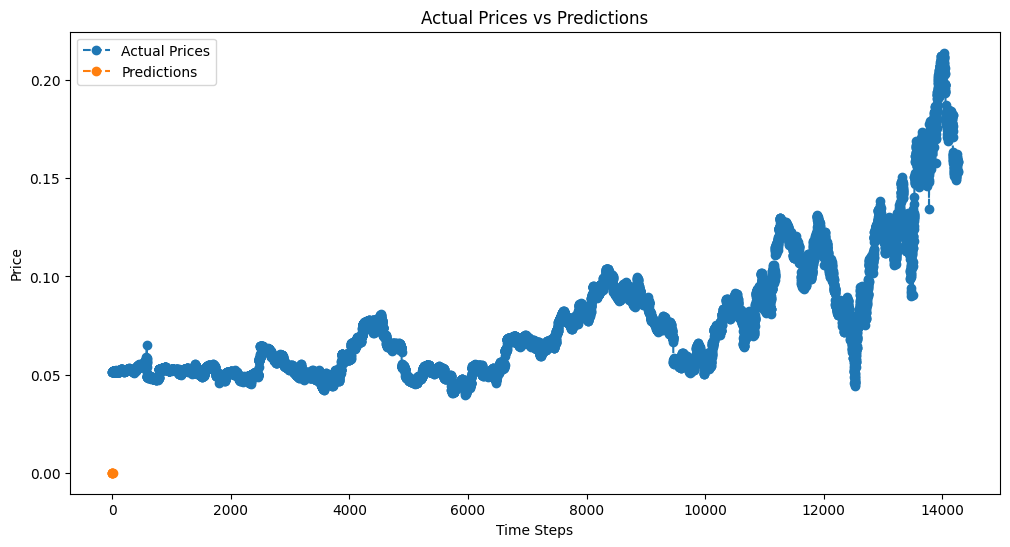

In [17]:
import matplotlib.pyplot as plt

# Inverse transform the test data and predictions

# test_data_inverse = scaler.inverse_transform(test_data)
prediction=scaler.fit_transform(prediction)
prediction_inverse = scaler.inverse_transform(prediction)

# Extract the actual prices
actual_prices = test_data[:, -1]  # Assuming the last column contains the prices

# Plot the actual prices and predictions
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', linestyle='--', marker='o')
plt.plot(prediction[0], label='Predictions', linestyle='--', marker='o')
plt.title('Actual Prices vs Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

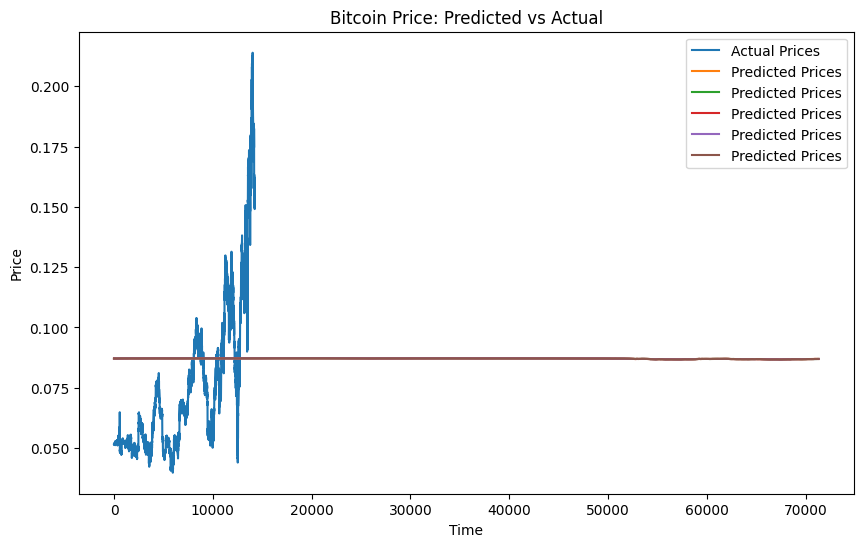

In [26]:
    # Inverse transform to get actual price values

#predicted_prices = scaler.inverse_transform(predictions[0])

    # Plotting predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title('Bitcoin Price: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

In [ ]:
# First, let's load the test dataset to understand its structure and how we can use it with the model.
import pandas as pd

# Load the dataset
dataset_path = '/kaggle/input/btc-usd-full-dataset/btc_3m.csv'
test_data_df = pd.read_csv(dataset_path)

# Display the first few rows of the dataset to understand its structure
test_data_df.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Extract the 'close' column
close_prices = test_data_df['close'].values.reshape(-1, 1)

# Normalize the data
# Assuming the same scale (0, 1) as used during training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

# Prepare the test data using the lookback and batch size from the model training
lookback = 20  # As per the training notebook
batch_size = 32  # As per the training notebook

def corrected_test_generator(data, lookback):
    num_samples = len(data) - lookback
    x_data = np.zeros((num_samples, lookback, 1))
    y_data = np.zeros((num_samples, 1))

    for i in range(num_samples):
        x_data[i] = data[i:i + lookback]
        y_data[i] = data[i + lookback]

    return x_data, y_data

# Create the test dataset using the corrected generator function
test_data, test_labels = corrected_test_generator(scaled_close_prices, lookback)

test_data.shape, test_labels.shape

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load the saved model
model = tf.keras.models.load_model('/kaggle/working/5pred.h5')

# Use the model to make predictions on the test data
predictions = model.predict(test_data)

# Evaluate the model (e.g., using Mean Squared Error)
mse = tf.keras.losses.MeanSquaredError()
mse_value = mse(test_labels, predictions).numpy()

# Inverse transform the predictions and actual values to their original scale
# This step assumes you have the 'scaler' used during preprocessing
inverse_predictions = scaler.inverse_transform(predictions)
inverse_actuals = scaler.inverse_transform(test_labels)

In [ ]:
# Ensure both arrays have the same length
min_length = min(len(inverse_actuals.flatten()), len(inverse_predictions.flatten()))
min_length
# inverse_actuals = inverse_actuals[:min_length]
# inverse_predictions = inverse_predictions[:min_length]

In [ ]:
# Prepare data for visualization
pred_vs_actual = pd.DataFrame({
    'Actual': inverse_actuals.flatten()[:min_length],
    'Predicted': inverse_predictions.flatten()[:min_length]
})

# Display the Mean Squared Error and the first few rows of predicted vs actual values
print(f"Mean Squared Error: {mse_value}")
print(pred_vs_actual.head())

# Optionally, you can visualize the results using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pred_vs_actual['Actual'], label='Actual Values')
plt.plot(pred_vs_actual['Predicted'], label='Predicted Values')
plt.title('Model Predictions vs Actual Values')
plt.legend()
plt.show()

In [ ]:
# Create a generator function to generate batches of training data
def generator(data, lookback, batch_size):
    if isinstance(data, pd.DataFrame):
        data = data.values

    i = 0
    while i + lookback < len(data):
        x = np.array([data[i:i + lookback]])
        y = np.array([data[i + lookback, 3]])  # Closing price for prediction
        i += 1
        yield x, y

In [ ]:
# Load the data
data1 = pd.read_csv("/kaggle/input/btc-usd-full-dataset/btc_3m.csv")
# Combine original data and normalized data
data1 = data1.loc[::-1].reset_index(drop=True)
data1 = data1[['close']]

# data1 = pd.concat([data1, pd.DataFrame(data, columns=data1.columns)], axis=1)

# Normalize the data
scaler = MinMaxScaler()
data1 = scaler.fit_transform(data1)

In [ ]:
data1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import tensorflow as tf
import datetime

# Combine original data and normalized data
# data1 = pd.concat([data1, pd.DataFrame(data, columns=data1.columns)], axis=1)

# Define the lookback and batch size
lookback = 20
batch_size = 32

# Load RNN model
model_rnn = load_model('/kaggle/working/5pred.h5')  # Replace with the appropriate model file

# Evaluate the model on the test data
test_gen_rnn = generator(data1, lookback, batch_size)
mse_rnn = model_rnn.evaluate(test_gen_rnn, steps=len(data1) // batch_size)

# Make predictions on new data
x_rnn = np.array([data1[-lookback:]])
predicted_signal_rnn = np.where(model_rnn.predict(x_rnn) > 0.5, 1, 0)

In [ ]:
data1 = pd.read_csv("/kaggle/input/btc-usd-full-dataset/btc_3m.csv")
data1 = data1.loc[::-1].reset_index(drop=True)
data1 = data1[['close']]

# Calculate RSI
rsi_period = 14
delta = data1['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=rsi_period, min_periods=1).mean()
avg_loss = loss.rolling(window=rsi_period, min_periods=1).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Calculate EMA
ema_span = 9
ema = data1['close'].ewm(span=ema_span, adjust=False).mean()

# Combine signals
data_signals = pd.DataFrame(index=data1.index)
data_signals['predicted_signal_rnn'] = 0
data_signals.loc[data1.index[-lookback:], 'predicted_signal_rnn'] = np.concatenate([predicted_signal_rnn.flatten(), np.zeros(lookback - len(predicted_signal_rnn.flatten()))])

# data_signals['predicted_signal_rnn'] = 0
# data_signals.loc[data1.index[-lookback:], 'predicted_signal_rnn'] = predicted_signal_rnn.flatten()[-lookback:]
# data_signals.loc[data1.index[-lookback:], 'predicted_signal_rnn'] = predicted_signal_rnn.flatten()
data_signals['rsi_signal'] = np.where(rsi > 70, -1, np.where(rsi < 30, 1, 0))
data_signals['ema_signal'] = np.where(data1['close'] > ema, 1, -1)

# Simulate trading with risk management using RNN, RSI, and EMA signals
initial_balance = 100000  # Starting balance in USD
balance = initial_balance
position = 0

# Define risk management parameters
stop_loss_percent = 0.02
position_size_percent = 0.1
risk_reward_ratio = 2
max_drawdown_limit = 0.05  # 5% maximum drawdown limit

# Lists to store trade-related information
trades = []
trade_dates = []

# Backtesting loop with risk management for RNN, RSI, and EMA
for i in range(1, len(data1)):
    # Buy signal from RNN
    if data_signals['predicted_signal_rnn'].iloc[i - 1] > 0.5:
        if balance > 0:
            position = min(balance / data1['close'].iloc[i - 1], initial_balance * position_size_percent)
            balance -= position * data1['close'].iloc[i - 1]
            trade_dates.append(data1.index[i])
            trades.append('Buy (RNN)')

    # Sell signal from RNN with risk management
    elif data_signals['predicted_signal_rnn'].iloc[i - 1] <= 0.5:
        if position > 0:
            stop_loss_price = data1['close'].iloc[i - 1] * (1 - stop_loss_percent)
            target_profit_price = data1['close'].iloc[i - 1] * (1 + risk_reward_ratio)

            # Execute stop-loss or take-profit based on prices
            if data1['close'].iloc[i] < stop_loss_price or data1['close'].iloc[i] > target_profit_price:
                balance += position * data1['close'].iloc[i - 1]
                position = 0
                trade_dates.append(data1.index[i])
                trades.append('Sell (RNN)')
            else:
                # Normal sell signal
                balance += position * data1['close'].iloc[i - 1]
                position = 0
                trade_dates.append(data.index[i])
                trades.append('Sell (RNN)')

        # Update maximum drawdown
        current_drawdown = (balance + position * data1['close'].iloc[i] - initial_balance) / initial_balance
        if current_drawdown < max_drawdown_limit:
            max_drawdown_limit = current_drawdown

# Buy and sell signals based on RSI
data_signals['rsi_buy_signal'] = np.where(data_signals['rsi_signal'] == 1, 1, 0)
data_signals['rsi_sell_signal'] = np.where(data_signals['rsi_signal'] == -1, -1, 0)

# Buy and sell signals based on EMA
data_signals['ema_buy_signal'] = np.where(data_signals['ema_signal'] == 1, 1, 0)
data_signals['ema_sell_signal'] = np.where(data_signals['ema_signal'] == -1, -1, 0)

# Combine all signals
data_signals['combined_signal'] = (
    data_signals['predicted_signal_rnn'] +
    data_signals['rsi_buy_signal'] +
    data_signals['rsi_sell_signal'] +
    data_signals['ema_buy_signal'] +
    data_signals['ema_sell_signal']
)

# Adjust combined signal to {-1, 0, 1}
data_signals['combined_signal'] = np.where(data_signals['combined_signal'] > 1, 1,
                                           np.where(data_signals['combined_signal'] < -1, -1, data_signals['combined_signal']))

# Simulate trading with risk management using combined signals
initial_balance_combined = 100000  # Starting balance in USD
balance_combined = initial_balance_combined
position_combined = 0

# Define risk management parameters
stop_loss_percent_combined = 0.02
position_size_percent_combined = 0.1
risk_reward_ratio_combined = 2
max_drawdown_limit_combined = 0.05  # 5% maximum drawdown limit

# Lists to store trade-related information
trades_combined = []
trade_dates_combined = []

# Backtesting loop with risk management for combined signals
for i in range(1, len(data1)):
    # Buy signal from combined signals
    if data_signals['combined_signal'].iloc[i - 1] > 0:
        if balance_combined > 0:
            position_combined = min(balance_combined / data1['close'].iloc[i - 1], initial_balance_combined * position_size_percent_combined)
            balance_combined -= position_combined * data1['close'].iloc[i - 1]
            trade_dates_combined.append(data1.index[i])
            trades_combined.append('Buy (Combined)')

    # Sell signal from combined signals with risk management
    elif data_signals['combined_signal'].iloc[i - 1] <= 0:
        if position_combined > 0:
            stop_loss_price_combined = data1['close'].iloc[i - 1] * (1 - stop_loss_percent_combined)
            target_profit_price_combined = data1['close'].iloc[i - 1] * (1 + risk_reward_ratio_combined)

            # Execute stop-loss or take-profit based on prices
            if data1['close'].iloc[i] < stop_loss_price_combined or data1['close'].iloc[i] > target_profit_price_combined:
                balance_combined += position_combined * data1['close'].iloc[i - 1]
                position_combined = 0
                trade_dates_combined.append(data1.index[i])
                trades_combined.append('Sell (Combined)')
            else:
                # Normal sell signal
                balance_combined += position_combined * data1['close'].iloc[i - 1]
                position_combined = 0
                trade_dates_combined.append(data1.index[i])
                trades_combined.append('Sell (Combined)')

        # Update maximum drawdown for combined signals
        current_drawdown_combined = (balance_combined + position_combined * data1['close'].iloc[i] - initial_balance_combined) / initial_balance_combined
        if current_drawdown_combined < max_drawdown_limit_combined:
            max_drawdown_limit_combined = current_drawdown_combined

# Calculate returns and additional metrics for RNN
returns_rnn = balance + position * data1['close'].iloc[-1] - initial_balance
total_trades_rnn = len(trades)
win_trades_rnn = trades.count('Sell (RNN)')
loss_trades_rnn = trades.count('Buy (RNN)')
win_rate_rnn = win_trades_rnn / total_trades_rnn if total_trades_rnn > 0 else 0
max_drawdown_rnn = (min(data1['close']) - max(data1['close'])) / max(data1['close'])

# Calculate returns and additional metrics for Combined Signals
returns_combined = balance_combined + position_combined * data1['close'].iloc[-1] - initial_balance_combined
total_trades_combined = len(trades_combined)
win_trades_combined = trades_combined.count('Sell (Combined)')
loss_trades_combined = trades_combined.count('Buy (Combined)')
win_rate_combined = win_trades_combined / total_trades_combined if total_trades_combined > 0 else 0
max_drawdown_combined = (min(data1['close']) - max(data1['close'])) / max(data1['close'])

# Display backtesting results for RNN and Combined Signals
print("RNN Backtesting Results:")
print(f"Returns: {returns_rnn}")
print(f"Total Trades: {total_trades_rnn}")
print(f"Win Trades: {win_trades_rnn}")
print(f"Loss Trades: {loss_trades_rnn}")
print(f"Win Rate: {win_rate_rnn}")
print(f"Max Drawdown: {max_drawdown_rnn}")

print("\nCombined Signals Backtesting Results:")
print(f"Returns: {returns_combined}")
print(f"Total Trades: {total_trades_combined}")
print(f"Win Trades: {win_trades_combined}")
print(f"Loss Trades: {loss_trades_combined}")
print(f"Win Rate: {win_rate_combined}")
print(f"Max Drawdown: {max_drawdown_combined}")

# 10 minutes prediction/forecasting

In [ ]:
# Define the lookback and batch size
lookback = 30
batch_size = 32

In [ ]:
# Create a generator function to generate batches of training data
def generator(data, lookback, batch_size):
    i = 0
    while i + lookback < len(data):
        x = np.array([data[i:i+lookback]])
        y = np.array([data[i+lookback]])
        i += 1
        yield x, y

# Create the RNN model
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(40, input_shape=(lookback, 1), activation='tanh'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(10))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
train_gen = generator(train_data, lookback, batch_size)
model.fit(train_gen, epochs=25, steps_per_epoch=len(train_data) // batch_size)

# Evaluate the model on the test data
test_gen = generator(test_data, lookback, batch_size)
mse = model.evaluate(test_gen, steps=len(test_data) // batch_size)

# Make predictions on new data
x = np.array([data[-lookback:]])
prediction = model.predict(x)
prediction = scaler.inverse_transform(prediction)
print("Prediction:", prediction)
print("MSE:", mse)

In [ ]:
model.save('10pred.h5')

# 20 minutes prediction/forecasting

In [ ]:
# Define the lookback and batch size
lookback = 60
batch_size = 32

In [ ]:
# Create a generator function to generate batches of training data
def generator(data, lookback, batch_size):
    i = 0
    while i + lookback < len(data):
        x = np.array([data[i:i+lookback]])
        y = np.array([data[i+lookback]])
        i += 1
        yield x, y

# Create the RNN model
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(50, input_shape=(lookback, 1), activation='tanh'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(20))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
train_gen = generator(train_data, lookback, batch_size)
model.fit(train_gen, epochs=30, steps_per_epoch=len(train_data) // batch_size)

# Evaluate the model on the test data
test_gen = generator(test_data, lookback, batch_size)
mse = model.evaluate(test_gen, steps=len(test_data) // batch_size)

# Make predictions on new data
x = np.array([data[-lookback:]])
prediction = model.predict(x)
prediction = scaler.inverse_transform(prediction)
print("Prediction:", prediction)
print("MSE:", mse)

In [ ]:
model.save('20pred.h5')

# Streamlit to demostrate the predictions

In [ ]:
!pip install streamlit

In [ ]:
import pandas as pd
import numpy as np
import datetime
import streamlit as st
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# Load sample data (replace with your actual dataset)
'''data = {
    'time': pd.date_range(start='2022-01-01', periods=150, freq='1T'),
    'close': np.random.rand(150) * 1000  # Replace with your actual close prices
}
df = pd.DataFrame(data)
'''
df=data

# Load the models
model_5mins = tf.keras.models.load_model('5pred.h5')
model_10mins = tf.keras.models.load_model('10pred.h5')
model_20mins = tf.keras.models.load_model('20pred.h5')

# Function to get predictions
def get_predictions(model, window_size):
    # Your logic to get predictions here
    return np.random.rand(window_size) * 1000  # Replace with your actual prediction logic

# Function to create the figure
def create_figure(df, predictions, timer_add):
    # Your logic to create the figure here
    fig = px.line(df, x="time", y="close", color_discrete_sequence=['#f9a03f'],
                  range_x=[df["time"].iloc[0], df["time"].iloc[-1]])
    fig.add_trace(go.Scatter(name="future_pred", x=timer_add, y=predictions, mode='lines', line=dict(color="crimson")))
    fig['layout']['xaxis'].update(autorange=True)
    return fig

# Streamlit app
st.image("https://upload.wikimedia.org/wikipedia/commons/4/46/Bitcoin.svg")
st.title("Real-time BTC/USDT future price predictor")
st.empty()
st.empty()
st.empty()

fig = None
col1, col2, col3 = st.columns(3)

with col1:
    if st.button("Predict (Next 5-mins)"):
        # Get predictions for 5 mins
        predictions_5mins = get_predictions(model_5mins, window_size=10)
        fig = create_figure(df, predictions_5mins, timer_add_5mins)
        st.write(fig)

# Repeat the same structure for other buttons (10 mins, 20 mins)
with col2:
    if st.button("Predict (Next 5-mins)"):
        # Get predictions for 10 mins
        predictions_10mins = get_predictions(model_10mins, window_size=10)
        fig = create_figure(df, predictions_10mins, timer_add_5mins)
        st.write(fig)
with col3:
    if st.button("Predict (Next 5-mins)"):
        # Get predictions for 20 mins
        predictions_20mins = get_predictions(model_20mins, window_size=10)
        fig = create_figure(df, predictions_20mins, timer_add_5mins)
        st.write(fig)